In [2]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import scipy
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from torch.autograd import Variable
import torch, torch.nn as nn
import torch.nn.functional as F

import scipy
import sklearn
import sklearn.metrics
import math

import library
import library.simulated_data

In [23]:
NUMBER_OF_INPUT_SIGNALS = 3
SIGNALS_LENGTH = int(1e6)
TARGET_LAG = 10

### GENERAL INFO
Number of signals:  3
Signals Length:  1000000
Lag Length:  10

### FILRERS
    Low  High
0  0.10  0.20
1  0.36  0.46
2  0.77  0.87

### MIXING MATRIX
    Signal0  Signal1  Signal2
W0     0.37     0.78     0.27
W1     0.08     0.04     0.25
W2     0.73     0.46     0.63

### WEIGHT MATRIX
    Signal0  Signal1  Signal2
W0     0.61     0.01     0.15
W1     0.44     0.57     0.92
W2     0.91     0.60     0.32
W3     0.86     0.44     0.48
W4     0.53     0.26     0.08
W5     0.06     0.23     0.47
W6     0.19     0.23     0.24
W7     0.87     0.71     0.52
W8     0.49     0.66     0.21
W9     0.79     0.07     0.22

## SIGNALS DEMONSTRATION



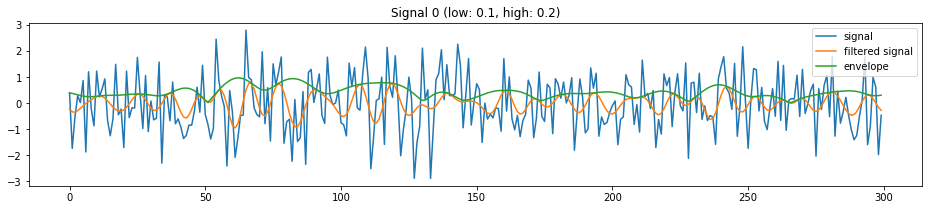

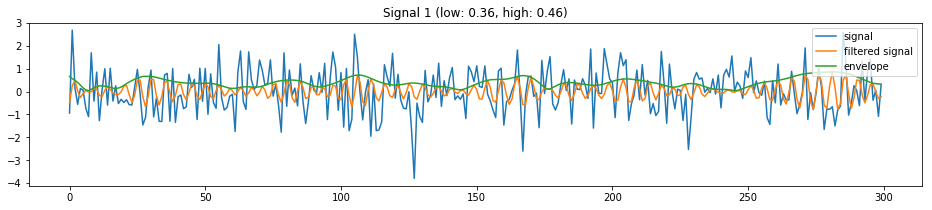

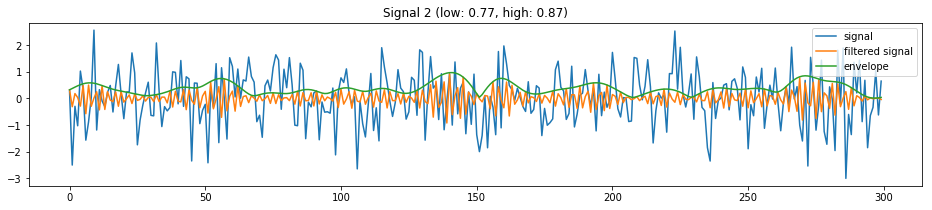

No handles with labels found to put in legend.



## SIGNALS DEMONSTRATION


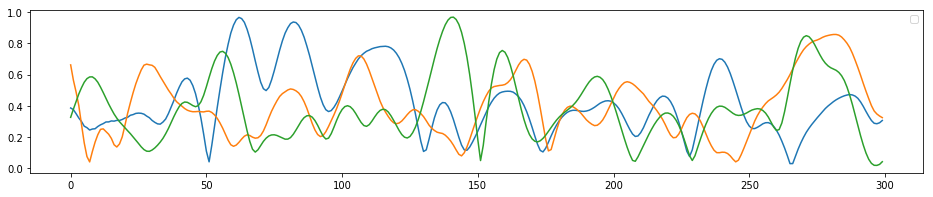

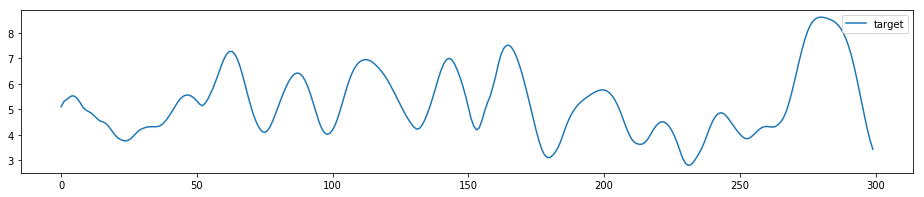

In [24]:
## Create our data
DataCreator = library.simulated_data.SimulatedDataCreator(NUMBER_OF_INPUT_SIGNALS, SIGNALS_LENGTH, TARGET_LAG)
DataCreator.create()
DataCreator.info()
DataCreator.demonstrate_random_signals(NUMBER_OF_INPUT_SIGNALS)
DataCreator.demonstrate_targets()

In [25]:
## unpack variables

MIXED_SIGNALS = DataCreator.mixed_signals
SIGNALS = DataCreator.signals
FILTERED_SIGNALS = DataCreator.filtered_signals
ENVELOPES = DataCreator.envelopes
TARGET = DataCreator.target

FILTERS = DataCreator.filters
MIXING_MATRIX = DataCreator.mixing_matrix
WEIGHT_MATRIX = DataCreator.weight_matrix

In [26]:
## Define input and target

X = MIXED_SIGNALS
Y = ENVELOPES
ntr = int(0.5 * X.shape[0])

In [40]:
class envelope_detector(nn.Module):
    def __init__(self):
        super(self.__class__,self).__init__()
        self.k1 = 34
        self.conv_filtering =  nn.Conv1d(1, 1, kernel_size = self.k1, bias=False)
        self.k2 = 100
        self.conv_envelope =  nn.Conv1d(1, 1, kernel_size = self.k2)
    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = self.conv_filtering(x)
        x = F.leaky_relu(x, negative_slope=-1)
        x = self.conv_envelope(x)
        return x
    

class neural_net(nn.Module):
    def __init__(self, signals, target_lag):
        super(self.__class__,self).__init__()
        self.signals = signals
        self.target_lag = target_lag
        self.ica = nn.Conv1d(self.signals, self.signals, 1, bias = False)
        self.detectors = nn.ModuleList()
        for i in range(self.signals):
            self.detectors.append(envelope_detector())
        self.wights = nn.Linear(self.signals*self.target_lag, 1)

    def forward(self, x):
        x = self.ica(x)
        out = []
        for i in range(self.signals):
            out.append(self.detectors[i](x[:,i,:]))
        x = torch.cat(out, dim=1)
        center = int(x.shape[-1]/2)
        #x  = x[:,:,center-self.target_lag:center]
        x  = x[:,:,center]
        #x = x.contiguous()
        #x = x.view(x.size()[0], -1)
        #x = self.wights(x)
        return x

In [42]:
batch_size = 500
lag_backward = 80
lag_forward = 80

model = neural_net(NUMBER_OF_INPUT_SIGNALS, TARGET_LAG).cuda()

print("Trainable params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_function = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001, weight_decay=0.0005)

for index, (low, high) in enumerate(FILTERS):
    model.detectors[index].conv_filtering.weight.data = torch.reshape(torch.FloatTensor(scipy.signal.firwin(34,  [low, high], fs=2, pass_zero = False)), [1, 1, 34]).cuda()


loss_history = []
pbar = tqdm_notebook()
for x_batch, y_batch in library.simulated_data.data_generator(X[:ntr], Y[:ntr], batch_size, lag_backward, lag_forward):
    #### Train
    model.train()
    assert x_batch.shape[0]==y_batch.shape[0]
    x_batch = Variable(torch.FloatTensor(x_batch)).cuda()
    y_batch = Variable(torch.FloatTensor(y_batch)).cuda()
    y_predicted = model(x_batch)
    loss = loss_function(y_predicted,y_batch)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.cpu().data.numpy())    
    pbar.update(1)
    eval_lag = min(100,len(loss_history))
    pbar.set_postfix(loss = np.mean(loss_history[-eval_lag:]))
    #### Log and print results
    if len(loss_history)>5000:
        break


Trainable params:  445
Total params:  445


In [43]:
Y_sliced = Y[lag_backward:-lag_forward if lag_forward > 0 else None]
Y_predicted = []
for x_batch, y_batch in library.simulated_data.data_generator(X, Y,
                                      batch_size, lag_backward, lag_forward, shuffle=False, infinite= False):
    #### Train
    assert x_batch.shape[0]==y_batch.shape[0]
    x_batch = Variable(torch.FloatTensor(x_batch)).cuda()
    y_batch = Variable(torch.FloatTensor(y_batch)).cuda()
    y_predicted = model(x_batch).cpu().data.numpy()
    Y_predicted.append(y_predicted)

Y_predicted = np.concatenate(Y_predicted, axis = 0)




            axis 0    axis 1    axis 2
----------  --------  --------  --------
train MSE   0.0       0.0       0.0
train corr  0.98      0.98      0.99
train r2    0.95      0.97      0.97

test MSE    0.0       0.0       0.0
test corr   0.98      0.98      0.99
test r2     0.95      0.97      0.97




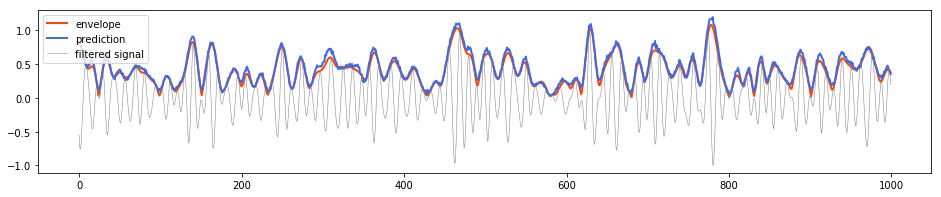

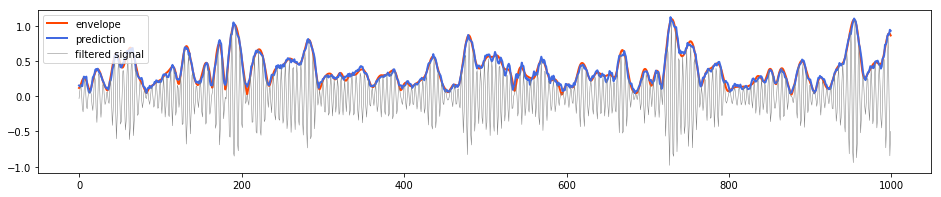

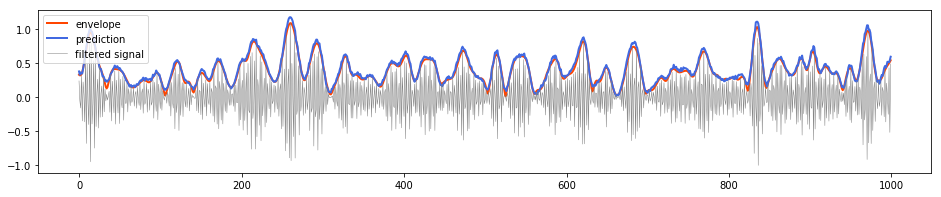

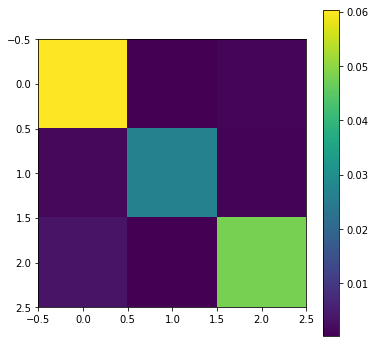

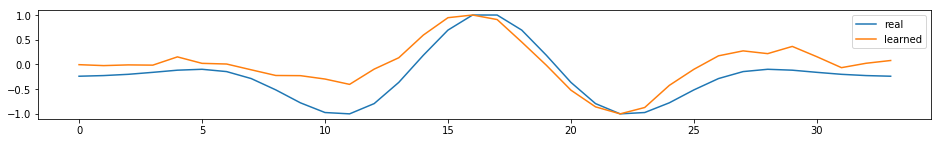

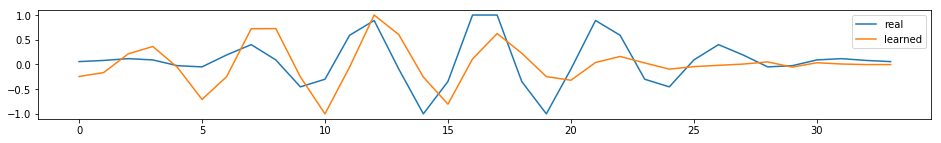

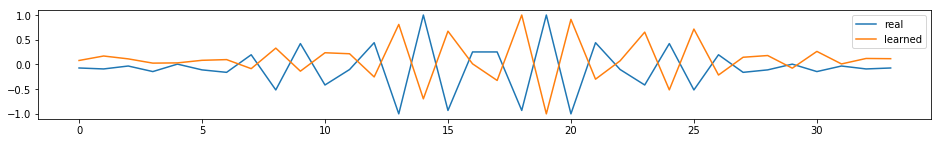

In [44]:
results_show(Y_sliced,Y_predicted, ntr, axes_names= [], filter_coef=None)
ntr_ = ntr + lag_forward

fsignal = np.copy(FILTERED_SIGNALS[lag_backward:-lag_forward if lag_forward > 0 else None])
samples = 1000
for i in range(Y_sliced.shape[1]):
    plt.figure(figsize=(16,3))
    plt.plot(Y_sliced[ntr_:ntr_+samples,i], linewidth=2, c="orangered", label = 'envelope') 
    plt.plot(Y_predicted[ntr_:ntr_+samples,i], linewidth=2, c="royalblue", label = 'prediction')
    plt.plot(fsignal[ntr_:ntr_+samples,i], linewidth=0.5, c = "gray", label = 'filtered signal')
    plt.legend(loc='upper left') 
    plt.show()

    
uniming_matrix = np.array(model.ica.state_dict()["weight"][:,:,0])

plt.figure(figsize=(6,6))
plt.imshow(np.abs(np.matmul(MIXING_MATRIX, uniming_matrix.transpose())))
plt.colorbar()
plt.show()

for index, (low, high) in enumerate(FILTERS):
    plt.figure(figsize=(16, 3))
    plt.plot(sklearn.preprocessing.minmax_scale((scipy.signal.firwin(34,  [low, high], fs=2, pass_zero = False)), [-1,1]), label = "real")
    plt.plot(sklearn.preprocessing.minmax_scale(np.array(model.detectors[index].conv_filtering.state_dict()["weight"])[0][0], [-1,1]), label = "learned")
    plt.legend()
    plt.show()

In [15]:
import tabulate
def results_show(Y,Y_predicted, ntr, axes_names= [], filter_coef=None):
    if axes_names == []:
        for name in range(Y.shape[1]):
            axes_names.append('axis ' + str(name))
    
    
    results_dict = {}
    for name in axes_names:
            results_dict[name]={'train': {}, 'test': {}}

    for axis, name in enumerate(axes_names):
        for part_of_data in ('train', 'test'):
            Y_pred_supp = Y_predicted
            Y_pred_supp = Y_pred_supp[:, axis].reshape((-1,1))
            Y_supp = Y[:, axis].reshape((-1,1))

            if part_of_data == 'train':
                Y_pred_supp = Y_pred_supp[:ntr]
                Y_supp = Y_supp[:ntr]
            else:
                Y_pred_supp = Y_pred_supp[ntr:]
                Y_supp = Y_supp[ntr:]

            results_dict[name][part_of_data]['MSE']=sklearn.metrics.mean_squared_error(Y_pred_supp,Y_supp)
            results_dict[name][part_of_data]['corr']=np.corrcoef(Y_pred_supp,Y_supp, rowvar = False)[0,1]
            results_dict[name][part_of_data]['r2']=sklearn.metrics.r2_score(Y_supp, Y_pred_supp)

    decim=3
    decim_corr=2
    
    results_list=[]
    for part_of_data in ('train', 'test'):
        for metric in ['MSE','corr','r2']:
            _ = [part_of_data+' '+metric]
            for axis in axes_names:
                    _.append(str(round(results_dict[axis][part_of_data][metric],2)))
            results_list.append(_)
        results_list.append(['']*(3+1))

    results=tabulate.tabulate(results_list,headers=['', *axes_names ])

    print (results)
    print ('')
    

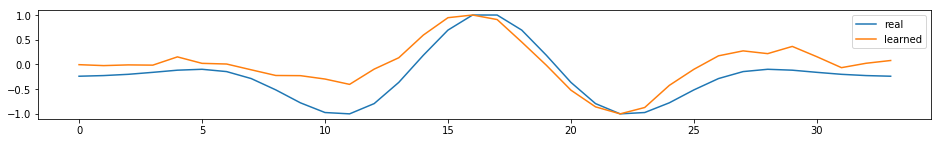

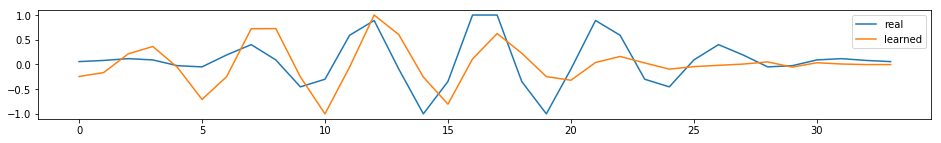

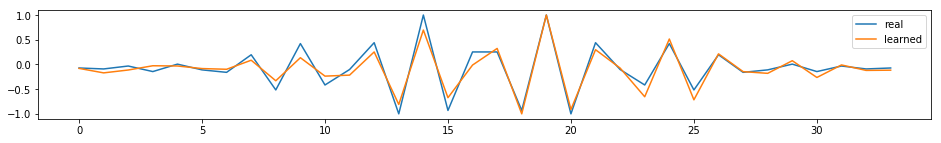

In [48]:
for index, (low, high) in enumerate(FILTERS):
    plt.figure(figsize=(16, 2))
    plt.plot(sklearn.preprocessing.minmax_scale((scipy.signal.firwin(34,  [low, high], fs=2, pass_zero = False)), [-1,1]), label = "real")
    if index!=2:
        plt.plot(sklearn.preprocessing.minmax_scale(np.array(model.detectors[index].conv_filtering.state_dict()["weight"])[0][0], [-1,1]), label = "learned")
    else:
        plt.plot(sklearn.preprocessing.minmax_scale(-np.array(model.detectors[index].conv_filtering.state_dict()["weight"])[0][0], [-1,1]), label = "learned")
    plt.legend()
    plt.show()